In [102]:
import requests
import pandas as pd
import json
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.express as px
import plotly.io as pio
from datetime import datetime
from typing import Optional

In [24]:
def read_credentials(file_path):
    """Reads Strava credentials from a JSON file."""
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

In [25]:
credentials_file = "/Users/xueyishu/Downloads/my_strava_credentials.json"
credentials = read_credentials(credentials_file)

In [26]:
my_client_id = credentials['client_id']
my_client_secret = credentials['client_secret']

In [28]:
redirect_uri = "http://localhost/exchange_token"  # This can be any valid URL

# Step 1: Get the authorization URL
auth_url = f"https://www.strava.com/oauth/authorize?client_id={
    my_client_id}&response_type=code&redirect_uri={redirect_uri}&approval_prompt=force&scope=read,activity:read"

print(f"Go to this URL to authorize: {auth_url}")

Go to this URL to authorize: https://www.strava.com/oauth/authorize?client_id=132488&response_type=code&redirect_uri=http://localhost/exchange_token&approval_prompt=force&scope=read,activity:read


In [29]:
# Step 2: Exchange the authorization code for an access token
code = input("Enter the code you received: ")

In [30]:
# URL for Strava's OAuth token endpoint
token_url = 'https://www.strava.com/oauth/token'

# Payload containing the necessary information to request an access token
payload = {
    'client_id': my_client_id,            # Your Strava app's client ID
    'client_secret': my_client_secret,    # Your Strava app's client secret
    # The authorization code received from Strava after user authorization
    'code': code,
    # The type of grant being requested, in this case, 'authorization_code'
    'grant_type': 'authorization_code'
}

# Make a POST request to the Strava token endpoint with the payload to exchange the authorization code for an access token
response = requests.post(token_url, data=payload)

# Parse the JSON response to extract the token data
token_data = response.json()

# Extract the access token from the response, which will be used for making authenticated requests to Strava's API
access_token = token_data['access_token']

# Extract the refresh token from the response, which can be used to obtain a new access token without reauthorization
refresh_token = token_data['refresh_token']

In [105]:
def get_activities_in_time_range(
    access_token: str,
    num_activities: int,
    start_datetime: Optional[str | datetime] = None,
    end_datetime: Optional[str | datetime] = None
) -> pd.DataFrame:
    """
    Fetches activities from Strava within a specified time range.

    Args:
        access_token (str): The OAuth access token for authenticating with the Strava API.
        num_activities (int): The number of activities to fetch.
        start_datetime (Optional[Union[str|datetime]]): The start of the time range. 
                                Can be a date string (YYYY-MM-DD) or a datetime object.
        end_datetime (Optional[Union[str|datetime]]): The end of the time range.
                                Can be a date string (YYYY-MM-DD) or a datetime object.

    Returns:
        pd.DataFrame: A DataFrame containing the fetched activities.
    """
    headers = {
        'Authorization': f'Bearer {access_token}'
    }

    activities_url = "https://www.strava.com/api/v3/athlete/activities"
    params = {
        'per_page': num_activities,  # Number of activities to fetch
        'page': 1                    # Page number
    }

    # Convert date strings to datetime objects if necessary
    if isinstance(start_datetime, str):
        start_datetime = datetime.strptime(start_datetime, "%Y-%m-%d")
    if isinstance(end_datetime, str):
        end_datetime = datetime.strptime(end_datetime, "%Y-%m-%d")

    # Convert the start and end datetimes to Unix timestamps and add them to params if provided
    if start_datetime:
        params['after'] = int(time.mktime(start_datetime.timetuple()))
    if end_datetime:
        params['before'] = int(time.mktime(end_datetime.timetuple()))

    response = requests.get(activities_url, headers=headers, params=params)
    return pd.DataFrame(response.json())

In [107]:
recent_3m_activities = get_activities_in_time_range(
    access_token, 100, "2024-06-01", "2024-09-01")

In [109]:
df = recent_3m_activities.copy()

In [110]:
palette_set3 = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072',
                '#80b1d3', '#fdb462', '#b3de69', '#fccde5',
                '#d9d9d9', '#bc80bd']

In [111]:
# Convert start_date to datetime format
df["start_date_local"] = pd.to_datetime(df["start_date_local"])

# Extract year and month
df["year_month"] = df["start_date_local"].dt.to_period("M")
df["week"] = df["start_date_local"].dt.to_period("W")


def plot_by_agg_period(data: pd.DataFrame, period_col: str) -> None:
    """
    Plots the total exercise time by type, aggregated by the specified time period.

    Args:
        data (pd.DataFrame): The DataFrame containing the exercise data.
        period_col (str): The column name for the time period to group by 
                          (e.g., 'year_month' or 'week').

    Returns:
        None
    """
    # Group by the specified period and type, then sum the moving time and convert to hours
    grouped_df = data.groupby([period_col, "type"])[
        "moving_time"].sum().reset_index()
    grouped_df["moving_time"] = grouped_df["moving_time"] / \
        3600  # Convert seconds to hours

    # Pivot table to have types as columns and periods as rows
    pivot_df = grouped_df.pivot(
        index=period_col, columns="type", values="moving_time"
    ).fillna(0)

    # Plotting
    pivot_df.plot(
        kind="bar", stacked=True, figsize=(12, 8), color=palette_set3, edgecolor="black"
    )

    plt.title("Total Exercise Time by Type")
    plt.xlabel("")
    plt.ylabel("Exercise Time (hours)")
    plt.xticks(rotation=45)
    plt.grid(axis="y")

    # Move the legend outside of the plot
    plt.legend(title="Exercise Type", bbox_to_anchor=(
        1.05, 1), loc="upper left")

    # Display the plot
    plt.show()

/var/folders/1t/hn2sdwfn1lx9rcvb_mkfkqz00000gn/T/ipykernel_10005/1696338648.py:5: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/var/folders/1t/hn2sdwfn1lx9rcvb_mkfkqz00000gn/T/ipykernel_10005/1696338648.py:6: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



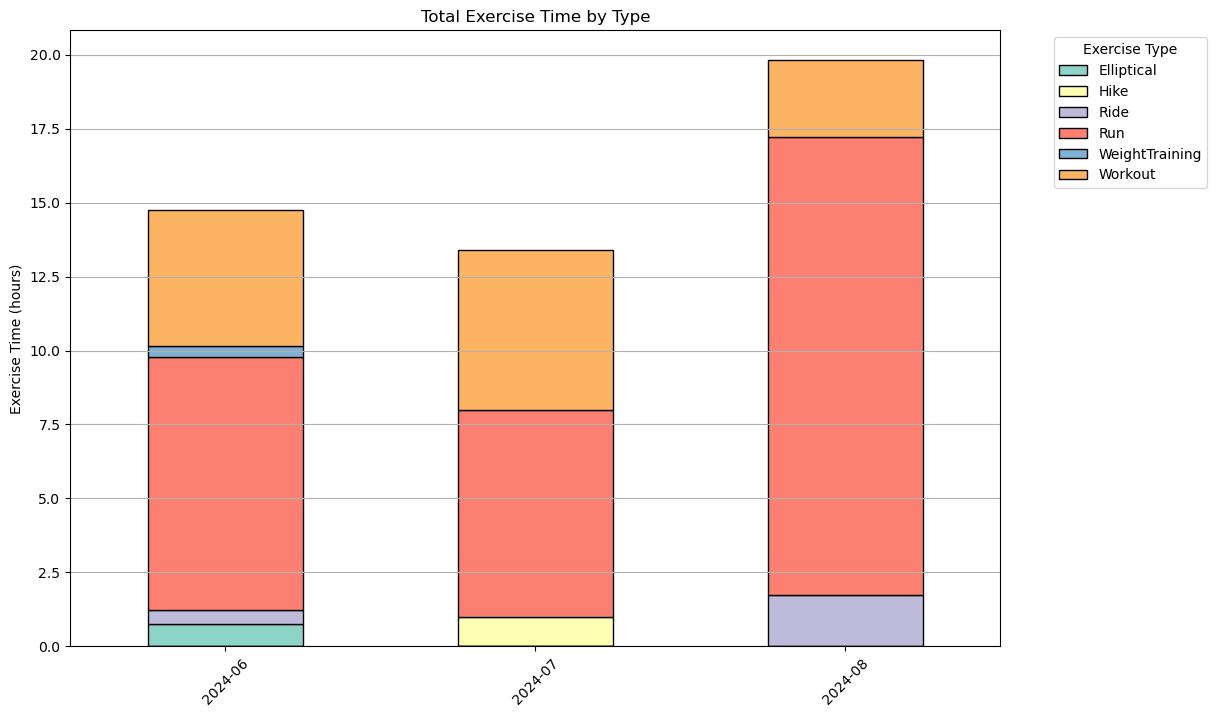

In [113]:
plot_by_agg_period(df, "year_month")

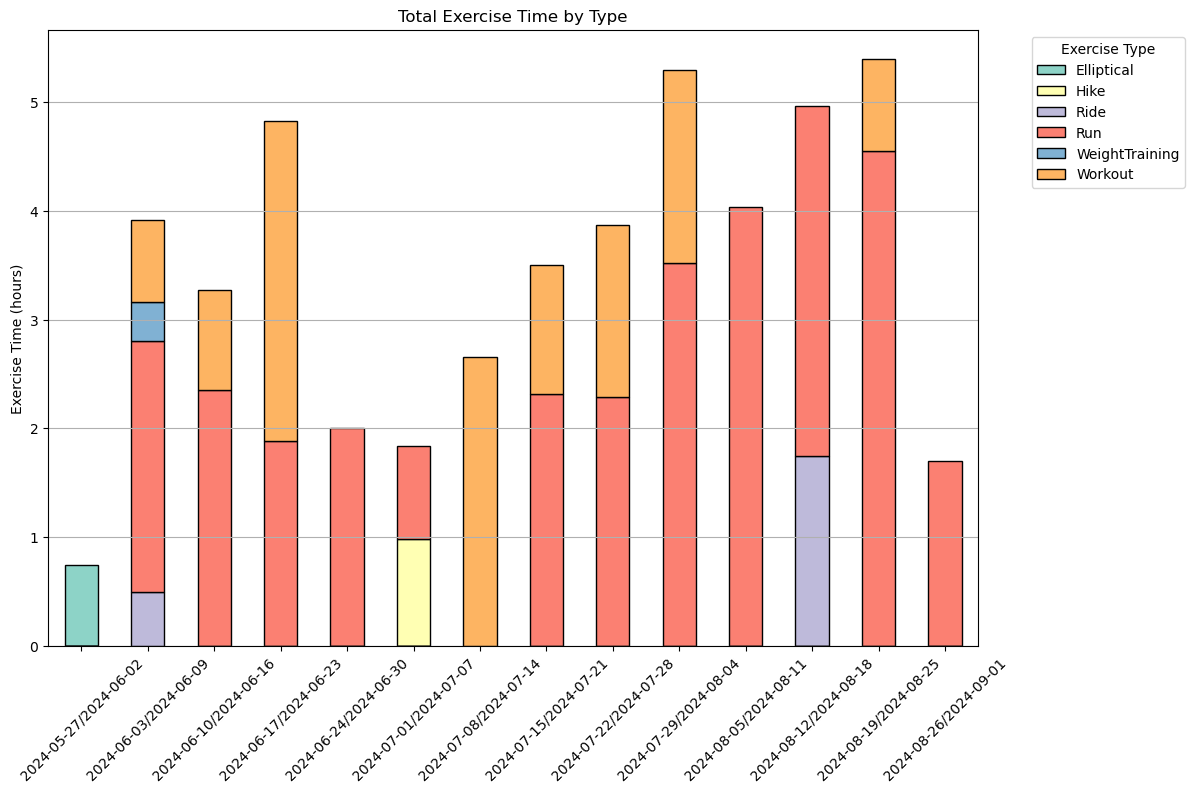

In [115]:
plot_by_agg_period(df, "week")

In [116]:
# Ensure that the 'start_date_local' and 'elapsed_time' columns are in the correct format
df['start_date_local'] = pd.to_datetime(df['start_date_local'])

In [117]:
# Convert moving_time from seconds to hours
df["time_spent_hours"] = df["moving_time"] / 3600

# Convert distance from meters to miles
df["distance_miles"] = df["distance"] * 0.000621371

# Group by day
df["day"] = df["start_date_local"].dt.to_period(
    "D").apply(lambda r: r.start_time)

daily_time = df.groupby(["day", "sport_type"])[
    "time_spent_hours"].sum().reset_index()
daily_distance = (
    df[df["sport_type"] == "Run"].groupby(
        "day")["distance_miles"].sum().reset_index()
)

# Group by week
df["week"] = df["start_date_local"].dt.to_period(
    "W").apply(lambda r: r.start_time)

weekly_time = df.groupby(["week", "sport_type"])[
    "time_spent_hours"].sum().reset_index()
weekly_distance = (
    df[df["sport_type"] == "Run"].groupby(
        "week")["distance_miles"].sum().reset_index()
)

# Group by month
df["month"] = df["start_date_local"].dt.to_period(
    "M").apply(lambda r: r.start_time)

monthly_time = (
    df.groupby(["month", "sport_type"])["time_spent_hours"].sum().reset_index()
)
monthly_distance = (
    df[df["sport_type"] == "Run"].groupby(
        "month")["distance_miles"].sum().reset_index()
)

# Plotting with Plotly

# Daily plots
fig_daily_time = px.bar(
    daily_time,
    x="day",
    y="time_spent_hours",
    color="sport_type",
    title="Time Spent on Activities by Day",
    labels={"time_spent_hours": "Hours", "day": "Day"},
)

fig_daily_distance = px.bar(
    daily_distance,
    x="day",
    y="distance_miles",
    title="Running Distance by Day",
    labels={"distance_miles": "Distance (Miles)", "day": "Day"},
)

# Weekly plots
fig_weekly_time = px.bar(
    weekly_time,
    x="week",
    y="time_spent_hours",
    color="sport_type",
    title="Time Spent on Activities by Week",
    labels={"time_spent_hours": "Hours", "week": "Week"},
)

fig_weekly_distance = px.bar(
    weekly_distance,
    x="week",
    y="distance_miles",
    title="Running Distance by Week",
    labels={"distance_miles": "Distance (Miles)", "week": "Week"},
)

# Monthly plots
fig_monthly_time = px.bar(
    monthly_time,
    x="month",
    y="time_spent_hours",
    color="sport_type",
    title="Time Spent on Activities by Month",
    labels={"time_spent_hours": "Hours", "month": "Month"},
)

fig_monthly_distance = px.bar(
    monthly_distance,
    x="month",
    y="distance_miles",
    title="Running Distance by Month",
    labels={"distance_miles": "Distance (Miles)", "month": "Month"},
)

/var/folders/1t/hn2sdwfn1lx9rcvb_mkfkqz00000gn/T/ipykernel_10005/327676784.py:8: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/var/folders/1t/hn2sdwfn1lx9rcvb_mkfkqz00000gn/T/ipykernel_10005/327676784.py:16: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/var/folders/1t/hn2sdwfn1lx9rcvb_mkfkqz00000gn/T/ipykernel_10005/327676784.py:24: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [118]:
# Save to HTML file
with open('strava_analysis.html', 'w') as f:
    f.write(fig_daily_time.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig_weekly_time.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig_monthly_time.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig_daily_distance.to_html(
        full_html=False, include_plotlyjs='cdn'))
    f.write(fig_weekly_distance.to_html(
        full_html=False, include_plotlyjs='cdn'))
    f.write(fig_monthly_distance.to_html(
        full_html=False, include_plotlyjs='cdn'))


print("HTML file 'strava_analysis.html' created with plots.")

HTML file 'strava_analysis.html' created with plots.
